## Gaussion Process Regression

This notebook loads various GP experiments and summarizes the result of experiments.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch

from synapse_utils import io

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from pyro.infer import TraceMeanField_ELBO
from pyro.infer.util import torch_backward, torch_item

import pickle

# assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(0)

In [2]:
repo_root = '../..'
run_id = 'synapseclr__so3__seed_42__second_stage'
output_root = f'../../output/checkpoint__{run_id}/analysis/gp'

trait_key_list = [
    'cleft_size_log1p_zscore',
    'presyn_soma_dist_log1p_zscore',
    'postsyn_soma_dist_log1p_zscore',
    'mito_size_pre_vx_log1p_zscore_zi',
    'mito_size_post_vx_log1p_zscore_zi',
    'pre_and_post_cell_types',
    'pre_cell_type',
    'post_cell_type',
    'has_mito_pre',
    'has_mito_post'
]

trait_key_short_map = {
    'cleft_size_log1p_zscore': 'CleftSize',
    'presyn_soma_dist_log1p_zscore': 'PreSomaDist',
    'postsyn_soma_dist_log1p_zscore': 'PostSomaDist',
    'mito_size_pre_vx_log1p_zscore_zi': 'PreMitoSize',
    'mito_size_post_vx_log1p_zscore_zi': 'PostMitoSize',
    'pre_and_post_cell_types': 'PrePostCellType',
    'pre_cell_type': 'PreCellType',
    'post_cell_type': 'PostCellType',
    'has_mito_pre': 'PreMito',
    'has_mito_post': 'PostMito'
}

In [3]:
experiment_results = []

for dirpath, dirnames, filenames in os.walk(output_root):
    for filename in filenames:
        if filename[-4:] == '.pkl':
            output_file_path = os.path.join(dirpath, filename)
            # load the results
            with open(output_file_path, 'rb') as f:
                loader = pickle.Unpickler(f)
                manifest = loader.load()
                eval_container_tk = loader.load()
                loss_container_dict = loader.load()

            print(output_file_path)

            experiment_results.append({
                'manifest': manifest,
                'eval_container_dict': eval_container_tk,
                'loss_container_dict': loss_container_dict
            })

../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__1.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__3.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__5.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__10.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__2.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__9.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/experiment__sixth_wave__0.pkl
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/gp/random_rbf_n_inducing/exper

In [4]:
import colorcet as cc

def reduce_k_fold_accuracy(experiment_result: dict) -> np.ndarray:
    return np.mean(experiment_result['eval_container_tk'], axis=-1)


def plot_losses(experiment_result: dict, ncols=5, **kwargs):
    
    manifest = experiment_result['manifest']
    loss_container_dict = experiment_result['loss_container_dict']
    eval_container_dict = experiment_result['eval_container_dict']
    
    trait_key_list = manifest['trait_key_list']
    trait_type_list = manifest['trait_type_list']
    trait_num_categories_list = manifest['trait_num_categories_list']
    k_fold = manifest['k_fold']
    n_traits = len(trait_key_list)

    nrows = int(np.ceil(len(trait_key_list) / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, **kwargs)
    
    for i in range(len(trait_key_list)):
        
        trait_key = trait_key_list[i]
        trait_type = trait_type_list[i]
        trait_num_categories = trait_num_categories_list[i]
        
        ax = axs.flatten()[i]
        ax2 = ax.twinx()
        
        for k in range(k_fold):
            
            color = cc.glasbey[k]
            
            # plot loss
            loss_data = loss_container_dict[(i, k)]
            ax.scatter(
                list(map(lambda x: x[0], loss_data)),
                list(map(lambda x: x[1], loss_data)),
                s=1,
                alpha=0.1,
                color=color,
                label=f'fold {k + 1}')
            
            # plot validation     
            if trait_type == 'continuous':
                
                ax2.plot(
                    list(map(lambda x: x[0], eval_container_dict[(i, k)]['train_explained_variance'])),
                    list(map(lambda x: 100. * x[1], eval_container_dict[(i, k)]['train_explained_variance'])),
                    marker='o',
                    markerfacecolor='none',
                    markersize=5,
                    lw=1,
                    color=color)
                
                ax2.plot(
                    list(map(lambda x: x[0], eval_container_dict[(i, k)]['test_explained_variance'])),
                    list(map(lambda x: 100. * x[1], eval_container_dict[(i, k)]['test_explained_variance'])),
                    marker='d',
                    markerfacecolor='none',
                    markersize=5,
                    lw=1,
                    color=color)
                
                ax2.set_ylabel('explained variance (%)')
                ax2.set_ylim((-5, 100))
                
            elif trait_type == 'categorical':
                
                eval_iter_list = list(
                    map(lambda x: x[0], eval_container_dict[(i, k)]['train_0_roc_auc']))
                
                train_mean_auc_list = [
                    np.mean([
                        eval_container_dict[(i, k)][f'train_{j}_roc_auc'][i_iter][1]
                        for j in range(trait_num_categories)])
                    for i_iter in range(len(eval_iter_list))]
                
                test_mean_auc_list = [
                    np.mean([
                        eval_container_dict[(i, k)][f'test_{j}_roc_auc'][i_iter][1]
                        for j in range(trait_num_categories)])
                    for i_iter in range(len(eval_iter_list))]
                
                ax2.plot(
                    eval_iter_list,
                    train_mean_auc_list,
                    marker='o',
                    markerfacecolor='none',
                    markersize=5,
                    lw=1,
                    color=color)
                
                ax2.plot(
                    eval_iter_list,
                    test_mean_auc_list,
                    marker='d',
                    markerfacecolor='none',
                    markersize=5,
                    lw=1,
                    color=color)                    
                
                ax2.set_ylabel('AUC')
                ax2.set_ylim((-0.05, 1.1))
        
        ax.set_title(trait_key_short_map[trait_key])
        ax.set_xlabel('steps')
        ax.set_ylabel('loss')
        
    for i in range(len(trait_key_list), len(axs.flatten())):
        axs.flatten()[i].axis('off')
        
    fig.tight_layout()
    
    
from collections import defaultdict


def str_repr(m, s):
    return f"{m:.3f} ± {s:.3f}"

def get_representation_name_from_checkpoint_path(checkpoint_path: str):
    if checkpoint_path.find('final') != -1 or checkpoint_path.find('synapseclr') != -1:
        return 'SynapseCLR'
    elif checkpoint_path.find('random') != -1:
        return 'Random'
    elif checkpoint_path.find('medical') != -1:
        return 'MedicalNet'
    else:
        return 'Unknown'
    
def get_feature_name_from_feature_hook(feature_hook: str):
    return {
        'encoder.fc': 'Backbone',
        'projector.mlp.0': 'Projection Middle',
        'projector.mlp.3': 'Projection Head'}[feature_hook]
    
def parse_experiment(
        experiment_result: dict,
        data: dict,
        include_train_validation: bool = False,
        exclude_trait_keys: set = {'pre_and_post_cell_types'}):
    
    manifest = experiment_result['manifest']
    eval_container_dict = experiment_result['eval_container_dict']
    
    trait_key_list = manifest['trait_key_list']
    trait_type_list = manifest['trait_type_list']
    trait_num_categories_list = manifest['trait_num_categories_list']
    k_fold = manifest['k_fold']
    n_traits = len(trait_key_list)
    
    data['Representation'].append(get_representation_name_from_checkpoint_path(manifest['checkpoint_path']))
    data['Feature'].append(get_feature_name_from_feature_hook(manifest['feature_hook']))
    data['L2'].append(manifest['l2_normalize'])
    if manifest['perform_pca']:
        data['PCA'].append(manifest['n_pca_features'])
    else:
        data['PCA'].append('N/A')
    
    try:  # the "first wave" did not include 'kernel_type' in the manifest (all using RBF)
        data['Kernel'].append(manifest['kernel_type'])
    except:
        data['Kernel'].append('rbf')

    if 'n_inducing_points' in manifest:
        data['Inducing Points'].append(manifest['n_inducing_points'])
    elif 'n_inducing_points_list' in manifest:
        data['Inducing Points'].append(manifest['n_inducing_points_list'][-1])
    else:
        raise RuntimeError

    # data['ELBO Type'].append(manifest['elbo_type'])
        
    for i in range(n_traits):
        trait_key = trait_key_list[i]
        trait_type = trait_type_list[i]
        trait_num_categories = trait_num_categories_list[i]
        
        if trait_key in exclude_trait_keys:
            continue

        if trait_type == 'continuous':
            train_mean_ev = 100. * np.mean([
                eval_container_dict[(i, k)]['train_explained_variance'][-1][-1]
                for k in range(k_fold)])
            train_std_ev = 100. * np.std([
                eval_container_dict[(i, k)]['train_explained_variance'][-1][-1]
                for k in range(k_fold)])

            test_mean_ev = 100. * np.mean([
                eval_container_dict[(i, k)]['test_explained_variance'][-1][-1]
                for k in range(k_fold)])
            test_std_ev = 100. * np.std([
                eval_container_dict[(i, k)]['test_explained_variance'][-1][-1]
                for k in range(k_fold)])

            if include_train_validation:
                data[trait_key_short_map[trait_key] + '_Train_EV'].append(str_repr(train_mean_ev, train_std_ev))
                data[trait_key_short_map[trait_key] + '_Test_EV'].append(str_repr(test_mean_ev, test_std_ev))
            else:
                data[trait_key_short_map[trait_key] + '_EV'].append(str_repr(test_mean_ev, test_std_ev))
                
        elif trait_type == 'categorical':

            if trait_num_categories > 2:
                
                for i_category in range(trait_num_categories):

                    train_mean_auc = np.mean([
                        eval_container_dict[(i, k)][f'train_{i_category}_roc_auc'][-1][-1]
                        for k in range(k_fold)])
                    train_std_auc = np.std([
                        eval_container_dict[(i, k)][f'train_{i_category}_roc_auc'][-1][-1]
                        for k in range(k_fold)])

                    test_mean_auc = np.mean([
                        eval_container_dict[(i, k)][f'test_{i_category}_roc_auc'][-1][-1]
                        for k in range(k_fold)])
                    test_std_auc = np.std([
                        eval_container_dict[(i, k)][f'test_{i_category}_roc_auc'][-1][-1]
                        for k in range(k_fold)])

                    if include_train_validation:
                        data[trait_key_short_map[trait_key] + f'_{i_category}_Train_AUC'].append(str_repr(train_mean_auc, train_std_auc))
                        data[trait_key_short_map[trait_key] + f'_{i_category}_Test_AUC'].append(str_repr(test_mean_auc, test_std_auc))
                    else:
                        data[trait_key_short_map[trait_key] + f'_{i_category}_AUC'].append(str_repr(test_mean_auc, test_std_auc))
                        
            else:
                    
                train_mean_auc = np.mean([
                    eval_container_dict[(i, k)][f'train_{0}_roc_auc'][-1][-1]
                    for k in range(k_fold)])
                train_std_auc = np.std([
                    eval_container_dict[(i, k)][f'train_{0}_roc_auc'][-1][-1]
                    for k in range(k_fold)])
                
                test_mean_auc = np.mean([
                    eval_container_dict[(i, k)][f'test_{0}_roc_auc'][-1][-1]
                    for k in range(k_fold)])
                test_std_auc = np.std([
                    eval_container_dict[(i, k)][f'test_{0}_roc_auc'][-1][-1]
                    for k in range(k_fold)])
                
                if include_train_validation:
                    data[trait_key_short_map[trait_key] + f'_Train_AUC'].append(str_repr(train_mean_auc, train_std_auc))
                    data[trait_key_short_map[trait_key] + f'_Test_AUC'].append(str_repr(test_mean_auc, test_std_auc))
                else:
                    data[trait_key_short_map[trait_key] + f'_AUC'].append(str_repr(test_mean_auc, test_std_auc))              
                

In [5]:
# generate dataframe
data = defaultdict(list)

for experiment_result in experiment_results:
    parse_experiment(experiment_result, data)

results_df = pd.DataFrame(data)

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)
results_df

,Representation,Feature,L2,PCA,Kernel,Inducing Points,CleftSize_EV,PreSomaDist_EV,PostSomaDist_EV,PreMitoSize_EV,PostMitoSize_EV,PreCellType_AUC,PostCellType_AUC,PreMito_AUC,PostMito_AUC
0,Random,Backbone,False,N/A,rbf,10,39.519 ± 1.870,2.028 ± 0.309,46.232 ± 1.867,21.872 ± 4.945,-0.210 ± 0.760,0.847 ± 0.019,0.736 ± 0.026,0.810 ± 0.021,0.808 ± 0.009
1,Random,Backbone,False,N/A,rbf,50,40.809 ± 1.575,0.664 ± 0.413,45.194 ± 2.310,20.920 ± 5.024,-3.014 ± 1.890,0.854 ± 0.014,0.770 ± 0.024,0.813 ± 0.025,0.813 ± 0.008
2,Random,Backbone,False,N/A,rbf,200,39.825 ± 1.580,1.122 ± 0.108,44.351 ± 2.474,19.670 ± 5.041,-4.024 ± 2.422,0.857 ± 0.014,0.775 ± 0.017,0.808 ± 0.029,0.811 ± 0.007
3,Random,Backbone,False,N/A,rbf,700,39.317 ± 1.675,1.014 ± 0.437,43.748 ± 2.589,18.382 ± 5.589,-3.939 ± 2.228,0.858 ± 0.015,0.778 ± 0.014,0.802 ± 0.031,0.803 ± 0.010
4,Random,Backbone,False,N/A,rbf,20,40.887 ± 1.954,1.329 ± 0.323,46.100 ± 1.802,20.832 ± 5.544,-2.085 ± 1.549,0.852 ± 0.016,0.757 ± 0.027,0.812 ± 0.024,0.813 ± 0.008
5,Random,Backbone,False,N/A,rbf,600,39.370 ± 1.586,1.071 ± 0.477,43.832 ± 2.507,18.595 ± 5.491,-3.909 ± 2.357,0.857 ± 0.015,0.778 ± 0.015,0.803 ± 0.032,0.804 ± 0.010
6,Random,Backbone,False,N/A,rbf,5,35.916 ± 1.991,1.512 ± 0.401,45.523 ± 2.185,17.618 ± 4.352,1.013 ± 1.285,0.841 ± 0.021,0.708 ± 0.021,0.804 ± 0.018,0.799 ± 0.011
7,Random,Backbone,False,N/A,rbf,400,39.584 ± 1.561,1.126 ± 0.248,44.002 ± 2.496,18.799 ± 5.445,-4.029 ± 2.565,0.857 ± 0.015,0.777 ± 0.015,0.804 ± 0.031,0.806 ± 0.009
8,Random,Backbone,False,N/A,rbf,500,39.438 ± 1.731,1.077 ± 0.230,43.760 ± 2.551,18.592 ± 5.442,-3.974 ± 2.544,0.857 ± 0.015,0.778 ± 0.015,0.803 ± 0.031,0.805 ± 0.009
9,Random,Backbone,False,N/A,rbf,300,39.634 ± 1.590,1.200 ± 0.163,44.049 ± 2.506,19.164 ± 5.188,-3.965 ± 2.603,0.858 ± 0.015,0.776 ± 0.016,0.805 ± 0.031,0.809 ± 0.007


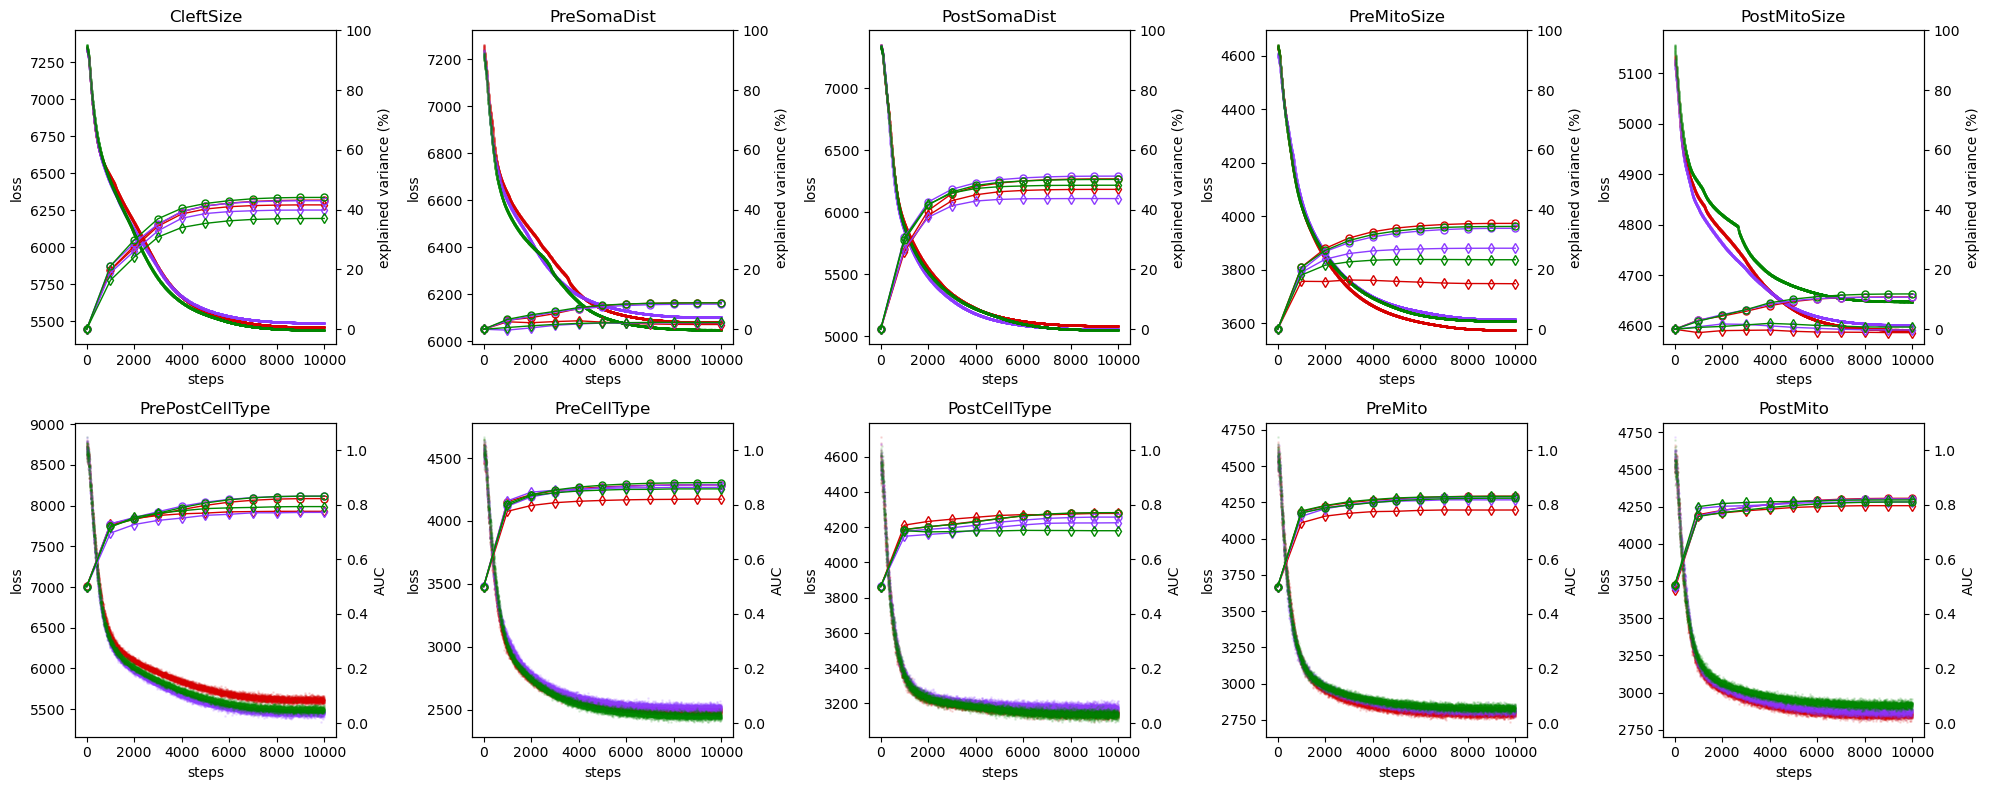

In [7]:
plot_losses(experiment_results[0], figsize=(20, 8))

## Select the best GP parameters for each representation

In [8]:
checkpoint_keyword_list = ['final', 'synapseclr']
feature_hook_list = ['encoder.fc']
kernel_type_list = ['rbf']
perform_pca = False

def any_hits(query: str, choices: list):
    for choice in choices:
        if query.find(choice) != -1:
            return True
    return False

filtered_experiment_results = []

for experiment_result in experiment_results:
    manifest = experiment_result['manifest']
    if not any_hits(manifest['checkpoint_path'], checkpoint_keyword_list):
        continue
    if not any_hits(manifest['feature_hook'], feature_hook_list):
        continue
    if not any_hits(manifest['kernel_type'], kernel_type_list):
        continue
    if manifest['perform_pca'] != perform_pca:
        continue
    filtered_experiment_results.append(experiment_result)
    
# generate dataframe
filtered_data = defaultdict(list)
for experiment_result in filtered_experiment_results:
    parse_experiment(experiment_result, filtered_data)    
filtered_results_df = pd.DataFrame(filtered_data)

# sort by n_inducing_points
filtered_results_df.sort_values(by='Inducing Points', inplace=True);

# remove duplicates
filtered_results_df.drop_duplicates(subset='Inducing Points', inplace=True);

# re-index
filtered_results_df.reset_index(drop=True, inplace=True);

In [9]:
filtered_results_df

,Representation,Feature,L2,PCA,Kernel,Inducing Points,CleftSize_EV,PreSomaDist_EV,PostSomaDist_EV,PreMitoSize_EV,PostMitoSize_EV,PreCellType_AUC,PostCellType_AUC,PreMito_AUC,PostMito_AUC
0,SynapseCLR,Backbone,False,N/A,rbf,5,64.984 ± 3.287,13.588 ± 1.876,51.616 ± 1.202,51.885 ± 3.941,9.556 ± 2.048,0.965 ± 0.005,0.922 ± 0.005,0.897 ± 0.059,0.838 ± 0.016
1,SynapseCLR,Backbone,False,N/A,rbf,10,66.533 ± 3.104,14.392 ± 1.872,52.224 ± 1.144,53.350 ± 3.824,9.968 ± 2.402,0.969 ± 0.005,0.930 ± 0.005,0.931 ± 0.016,0.841 ± 0.014
2,SynapseCLR,Backbone,False,N/A,rbf,20,67.531 ± 2.956,15.284 ± 1.803,52.763 ± 1.176,54.531 ± 3.775,9.804 ± 2.568,0.973 ± 0.004,0.938 ± 0.002,0.933 ± 0.016,0.847 ± 0.014
3,SynapseCLR,Backbone,False,N/A,rbf,50,68.779 ± 2.871,15.812 ± 1.549,53.551 ± 1.497,56.184 ± 3.349,8.733 ± 2.801,0.974 ± 0.004,0.939 ± 0.001,0.936 ± 0.016,0.851 ± 0.011
4,SynapseCLR,Backbone,False,N/A,rbf,100,69.454 ± 2.791,15.938 ± 1.426,53.882 ± 1.580,56.489 ± 3.138,7.398 ± 2.515,0.975 ± 0.004,0.940 ± 0.004,0.938 ± 0.016,0.854 ± 0.010
5,SynapseCLR,Backbone,False,N/A,rbf,200,69.882 ± 2.683,15.481 ± 1.244,53.902 ± 1.584,56.785 ± 3.144,5.441 ± 2.534,0.975 ± 0.004,0.940 ± 0.005,0.939 ± 0.015,0.856 ± 0.010
6,SynapseCLR,Backbone,False,N/A,rbf,300,69.966 ± 2.637,14.768 ± 1.023,53.801 ± 1.745,56.869 ± 3.091,4.002 ± 2.583,0.975 ± 0.003,0.939 ± 0.006,0.939 ± 0.015,0.857 ± 0.010
7,SynapseCLR,Backbone,False,N/A,rbf,400,70.017 ± 2.669,14.371 ± 0.969,53.791 ± 1.853,56.824 ± 3.013,2.770 ± 2.611,0.975 ± 0.004,0.938 ± 0.007,0.939 ± 0.015,0.856 ± 0.011
8,SynapseCLR,Backbone,False,N/A,rbf,500,70.003 ± 2.635,13.930 ± 0.794,53.645 ± 2.002,56.861 ± 2.975,1.990 ± 2.868,0.975 ± 0.004,0.937 ± 0.008,0.939 ± 0.015,0.855 ± 0.011
9,SynapseCLR,Backbone,False,N/A,rbf,600,69.950 ± 2.622,13.597 ± 0.797,53.612 ± 2.048,56.759 ± 2.926,1.042 ± 2.806,0.975 ± 0.004,0.936 ± 0.008,0.938 ± 0.015,0.855 ± 0.011


In [10]:
filtered_results_df.to_csv(
    os.path.join(output_root, 'synapse_simclr_backbone__n_inducing_points.csv'), index=None)

CleftSize_EV: 400
PreSomaDist_EV: 100
PostSomaDist_EV: 200
PreMitoSize_EV: 300
PostMitoSize_EV: 10
PreCellType_AUC: 100
PostCellType_AUC: 100
PreMito_AUC: 200
PostMito_AUC: 300


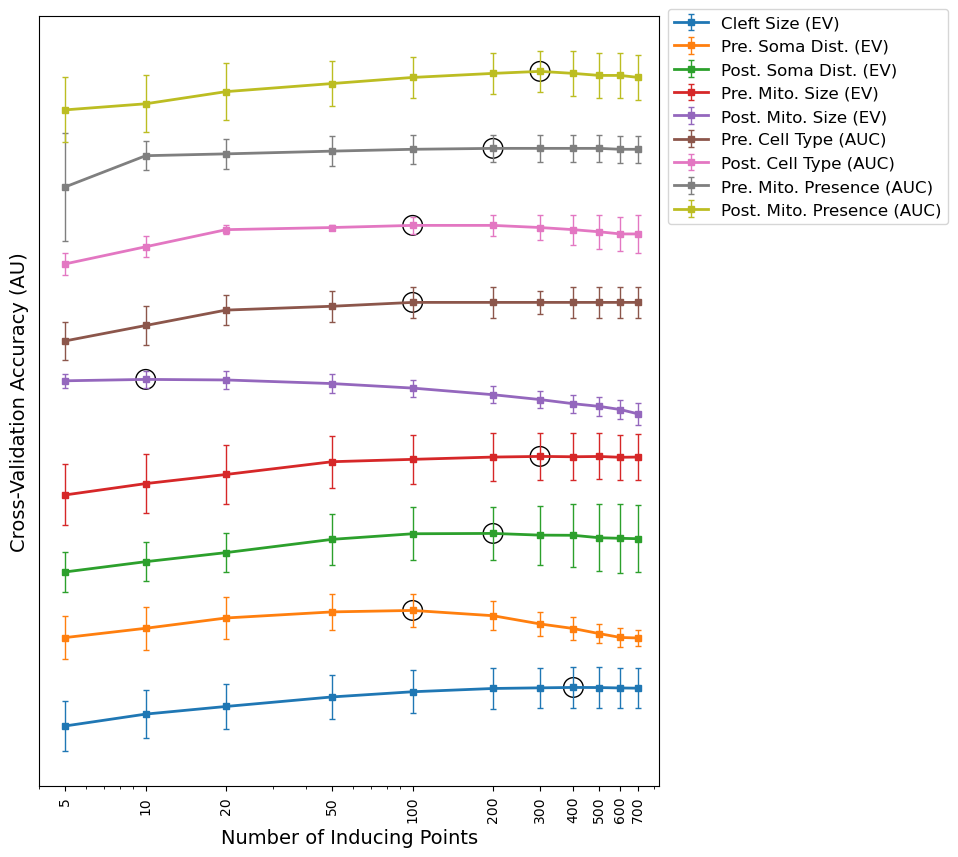

In [11]:
examined_traits = [
    'CleftSize_EV',
    'PreSomaDist_EV',
    'PostSomaDist_EV',
    'PreMitoSize_EV',
    'PostMitoSize_EV',
    'PreCellType_AUC',
    'PostCellType_AUC',
    'PreMito_AUC',
    'PostMito_AUC'
]

examined_traits_plot_labels = [
    'Cleft Size (EV)',
    'Pre. Soma Dist. (EV)',
    'Post. Soma Dist. (EV)',
    'Pre. Mito. Size (EV)',
    'Post. Mito. Size (EV)',
    'Pre. Cell Type (AUC)',
    'Post. Cell Type (AUC)',
    'Pre. Mito. Presence (AUC)',
    'Post. Mito. Presence (AUC)',
]

def str_repr_to_mean_std(str_repr):
    tokens = str_repr.split('±')
    return float(tokens[0].strip()), float(tokens[1].strip())


trait_cv_series = defaultdict(list)

max_considered_n_inducing_points = 700
n_inducing_points = filtered_results_df['Inducing Points'].values
max_inducing_points_idx = np.argmax(n_inducing_points > max_considered_n_inducing_points)
if max_inducing_points_idx <= 0:
    max_inducing_points_idx = len(n_inducing_points)
    
for trait in examined_traits:
    values = filtered_results_df[trait].values
    means = [str_repr_to_mean_std(value)[0] for value in values]
    stds = [str_repr_to_mean_std(value)[1] for value in values]
    trait_cv_series[trait + '__mean'] = means
    trait_cv_series[trait + '__std'] = stds
    
fig, ax = plt.subplots(figsize=(8, 10))

for i, trait in enumerate(examined_traits):
    v = trait_cv_series[trait + '__mean']
    e = trait_cv_series[trait + '__std']
    e = e / (np.max(v) - np.min(v))
    v = (v - np.min(v)) / (np.max(v) - np.min(v))
    
    x = n_inducing_points * np.exp(0.0 * (i - 0.5 * len(examined_traits)))
    y = v + 2. * i
    
    ax.errorbar(
        x[:max_inducing_points_idx],
        y[:max_inducing_points_idx],
        yerr=e[:max_inducing_points_idx],
        marker='s',
        markersize=4,
        lw=2,
        capsize=2,
        elinewidth=1,
        label=examined_traits_plot_labels[i])
    
    best_idx = min(np.argmax(v), max_inducing_points_idx - 1)
    
    ax.scatter(
        x[best_idx],
        y[best_idx],
        marker='o',
        s=200,
        facecolor='none',
        edgecolor='black')
    
    print(f'{trait}: {n_inducing_points[best_idx]}')

ax.set_xscale('log')
ax.set_xticks(n_inducing_points[:max_inducing_points_idx]);
ax.set_xticklabels(n_inducing_points[:max_inducing_points_idx], rotation=90);
ax.set_xlim((4, 1.2 * max(n_inducing_points[:max_inducing_points_idx])))
ax.legend(bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Cross-Validation Accuracy (AU)', fontsize=14)
ax.set_xlabel('Number of Inducing Points', fontsize=14)

fig.savefig(os.path.join(output_root, f'optimal_inducing_point__{checkpoint_keyword_list[0]}.pdf'), bbox_inches='tight')

## Generate the final cross-validation accuracy table

In [12]:
included_traits = [
    'CleftSize_EV',
    'PreSomaDist_EV',
    'PostSomaDist_EV',
    'PreMitoSize_EV',
    'PostMitoSize_EV',
    'PreCellType_AUC',
    'PostCellType_AUC',
    'PreMito_AUC',
    'PostMito_AUC'
]

checkpoint_feature_tuple_list = [
    (['random'], ['encoder.fc']),
    (['medical'], ['encoder.fc']),
    (['final'], ['projector.mlp.3']),
    (['final'], ['projector.mlp.0']),
    (['final'], ['encoder.fc'])]

source_list = [
    'N/A',
    'MedicalNet',
    'Ours',
    'Ours',
    'Ours',
]

method_list = [
    'Random 3D ResNet-18',
    'Pretrained [MedicalNet]',
    'Self-Supervised [Ours]',
    'Self-Supervised [Ours]',
    'Self-Supervised [Ours]',
]

feature_list = [
    'Backbone',
    'Backbone',
    'Projection Middle',
    'Projection Head',
    'Backbone',
]

kernel_type_list = ['rbf']
perform_pca = False

def any_hits(query: str, choices: list):
    for choice in choices:
        if query.find(choice) != -1:
            return True
    return False

def str_repr_to_mean_std(str_repr):
    tokens = str_repr.split('±')
    return float(tokens[0].strip()), float(tokens[1].strip())

def select_best_row(results_df, included_traits, prepend_columns_dict):
    best_values = []
    for trait in included_traits:
        best_row_idx = np.argmax([str_repr_to_mean_std(v)[0] for v in results_df[trait].values])
        best_value = results_df[trait].values[best_row_idx]
        best_values.append(best_value)
    
    return pd.DataFrame(
        dict(
            **prepend_columns_dict,
            **{trait: [value] for trait, value in zip(included_traits, best_values)}
        )
    )

filtered_results_df_list = []

for i, (checkpoint_keyword_list, feature_hook_list) in enumerate(checkpoint_feature_tuple_list):

    filtered_experiment_results = []
    for experiment_result in experiment_results:
        manifest = experiment_result['manifest']
        if not any_hits(manifest['checkpoint_path'], checkpoint_keyword_list):
            continue
        if not any_hits(manifest['feature_hook'], feature_hook_list):
            continue
        if not any_hits(manifest['kernel_type'], kernel_type_list):
            continue
        if manifest['perform_pca'] != perform_pca:
            continue
        filtered_experiment_results.append(experiment_result)
    
    # generate dataframe
    filtered_data = defaultdict(list)
    for experiment_result in filtered_experiment_results:
        parse_experiment(experiment_result, filtered_data)    
    filtered_results_df = pd.DataFrame(filtered_data)

    # sort by n_inducing_points
    filtered_results_df.sort_values(by='Inducing Points', inplace=True);

    # remove duplicates
    filtered_results_df.drop_duplicates(subset='Inducing Points', inplace=True);

    # re-index
    filtered_results_df.reset_index(drop=True, inplace=True);
    
    # select best row
    prepend_columns_dict = {
        'Method': [method_list[i]],
        'Feature': [feature_list[i]]}
    
    filtered_results_df = select_best_row(filtered_results_df, included_traits, prepend_columns_dict)

    filtered_results_df_list.append(filtered_results_df)

In [13]:
final_results_df = pd.concat(filtered_results_df_list)
final_results_df.reset_index(drop=True, inplace=True)
final_results_df

,Method,Feature,CleftSize_EV,PreSomaDist_EV,PostSomaDist_EV,PreMitoSize_EV,PostMitoSize_EV,PreCellType_AUC,PostCellType_AUC,PreMito_AUC,PostMito_AUC
0,Random 3D ResNet-18,Backbone,40.887 ± 1.954,2.028 ± 0.309,46.232 ± 1.867,21.872 ± 4.945,1.013 ± 1.285,0.858 ± 0.015,0.778 ± 0.015,0.813 ± 0.025,0.813 ± 0.008
1,Pretrained [MedicalNet],Backbone,49.204 ± 2.868,9.297 ± 1.683,53.262 ± 1.225,41.914 ± 4.548,5.080 ± 1.782,0.917 ± 0.027,0.836 ± 0.016,0.852 ± 0.020,0.844 ± 0.015
2,Self-Supervised [Ours],Projection Middle,60.964 ± 3.280,8.246 ± 1.905,49.055 ± 0.810,48.776 ± 4.049,2.821 ± 2.113,0.954 ± 0.009,0.918 ± 0.005,0.914 ± 0.023,0.829 ± 0.004
3,Self-Supervised [Ours],Projection Head,66.056 ± 2.935,13.675 ± 1.931,51.367 ± 1.125,53.930 ± 4.064,5.943 ± 2.812,0.966 ± 0.005,0.931 ± 0.002,0.931 ± 0.014,0.833 ± 0.014
4,Self-Supervised [Ours],Backbone,70.017 ± 2.669,15.938 ± 1.426,53.902 ± 1.584,56.869 ± 3.091,9.968 ± 2.402,0.975 ± 0.004,0.940 ± 0.004,0.939 ± 0.015,0.857 ± 0.010


In [14]:
final_results_df.to_csv(os.path.join(output_root, 'final_table.csv'), index=None)